In [90]:
import os
import argparse
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, ELU, Lambda, Dropout, Flatten, Dense

In [44]:
# Display settings
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [189]:
def load_data(data_folders):
    dfs = []
    for d in data_folders:
        df = pd.read_csv(d + 'driving_log.csv') 
        df.center = d + df.center.str.strip()
        df.left = d + df.left.str.strip()
        df.right = d + df.right.str.strip()
        dfs.append(df.copy())
    return pd.concat(dfs, ignore_index=True)

In [194]:
def shift_steering(df, shift_value=0.25):
    center = df[['center', 'steering']].rename(columns={'center': 'image_path'})
    left = df[['left', 'steering']].rename(columns={'left': 'image_path'})
    right = df[['right', 'steering']].rename(columns={'right': 'image_path'})
    left['steering'] = np.minimum(left['steering'] + shift_value, 1.)
    right['steering'] = np.maximum(right['steering'] - shift_value, -1.)
    return pd.concat((center, left, right), ignore_index=True)

In [372]:
def crop_roi(img, y1, y2, x1, x2):
    return img[y1:y2, x1:x2]

In [ ]:
def resize(img, new_x=200, new_y=66):
    return cv2.resize(img, dsize=(new_x, new_y))

In [198]:
def threshold_steering(steer_value):
    if steer_value < -1:
        return -1
    if steer_value > 1:
        return 1
    return steer_value

In [297]:
def random_translation(image, steer_value, trans_range=40, steer_adjust=0.01):
    x_shift = trans_range * np.random.uniform() - trans_range/2
    M = np.float32([[1, 0, x_shift], [0, 1, 0]])
    new_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    new_steering = threshold_steering(steer_value + steer_adjust * x_shift)
    return new_image, new_steering

In [267]:
def random_rotation(image, steer_value, angle_range=20, steer_multiplier=1.5):
    r, c, _ = image.shape
    angle = np.random.uniform(angle_range) - angle_range/2
    M = cv2.getRotationMatrix2D((c/2, r/2), angle, 1.0)
    new_image = cv2.warpAffine(image, M, (c, r), flags=cv2.INTER_LINEAR)
    new_steering = threshold_steering(angle/90 * steer_multiplier) * -1
    return new_image, new_steering

In [333]:
def random_brightness(img, a=0.4, b=1.2, return_hsv=True):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    factor = np.random.uniform(a, b)
    hsv[...,2] = np.minimum(hsv[...,2] * factor, 255)
    if return_hsv:
        return hsv
    return cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

In [192]:
df = load_data(['./data/sim_data/','./data/udacity_data/'])

In [195]:
df = shift_steering(df)

-0.5459642


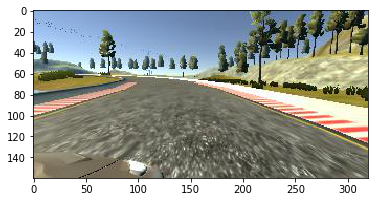

In [361]:
sample = df.sample(1)
img = cv2.imread(sample.image_path.values[0])
steer = sample.steering.values[0]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(steer)

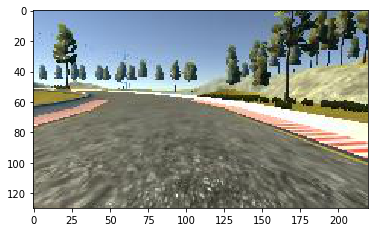

In [370]:
new_img = crop_image(img, 10, 140, 50, 270)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

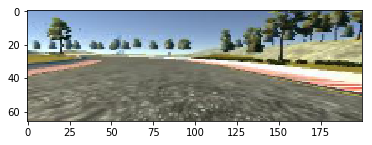

In [371]:
plt.imshow(cv2.cvtColor(cv2.resize(new_img, (200,66)), cv2.COLOR_BGR2RGB))